In [12]:
import cv2
from PIL import Image
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def image_arrs(paths, im_arr):
    for path in paths:
        #read images, may need to change filepath
        image = cv2.imread('../GTSRB/'+path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize all images to 30x30
        size_image = image_from_array.resize((30, 30))
        #convert images to array
        image_arr = np.array(size_image.getdata(),
                        np.uint8).reshape(size_image.size[1], size_image.size[0], 3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [14]:
#this may take a minute
df = pd.read_csv('../GTSRB/Train.csv')
#all filepaths for class 1 and 2
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

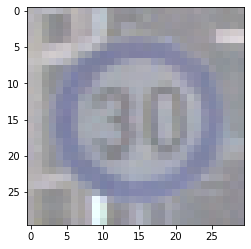

In [15]:
#class 1
ex1 = class1_arrs[0].reshape(30, 30, 3)
plt.imshow(ex1)

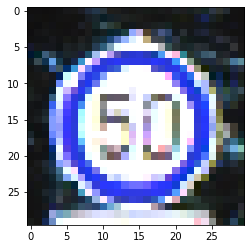

In [16]:
#class 2
ex2 = class2_arrs[100].reshape(30, 30, 3)
plt.imshow(ex2)

In [17]:
#define logreg model
class Model(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear = nn.Linear(D,1)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

In [18]:
#scale train set
train_X = class1_arrs + class2_arrs
train_y = len(class1_arrs)*[0]+len(class2_arrs)*[1]
train_X = preprocessing.scale(train_X, axis=1)

In [19]:
#scale test set
df = pd.read_csv('../GTSRB/Test.csv')
#all filepaths for class 1 and 2
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)
test_X = class1_arrs + class2_arrs
test_y = len(class1_arrs)*[0]+len(class2_arrs)*[1]
test_X = preprocessing.scale(test_X, axis=1)

In [20]:
#sklearn baseline
model = LogisticRegression()
model.fit(train_X, train_y)
print('Training accuracy:', model.score(train_X, train_y))
print('Validation accuracy:', model.score(test_X, test_y))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy: 1.0
Validation accuracy: 0.9231292517006803


In [21]:
#convert to tensor
train_X = torch.from_numpy(train_X).float()
test_X = torch.from_numpy(test_X).float()
train_y = torch.from_numpy(np.array(train_y).reshape(-1,1)).float()
test_y = torch.from_numpy(np.array(test_y).reshape(-1,1)).float()

In [22]:
#use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
#instanciate model and move to gpu
model = Model(train_X.shape[1]).to(device)

In [24]:
#define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

In [27]:
#number of iterations
epochs = 1200

#used to keep track of the changes in accuracy and loss
running_loss = 0
train_accs = []
test_accs = []
losses = []

#train on gpu
train_X = train_X.to(device)
test_X = test_X.to(device)
train_y = train_y.to(device)
test_y = test_y.to(device)

#training loop
for e in range(epochs):

    #standard training steps
    pred = model.forward(train_X)
    loss = criterion(pred, train_y)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #store current loss and accuracy for validation and training set
    if e%25==0 and e>0:
        running_loss /= 100
        losses.append(running_loss)
        running_loss = 0
        pred = torch.round(pred)
        train_acc = torch.sum(
            pred==train_y).float()/len(pred)
        train_accs.append(train_acc.item())
        pred = model.forward(test_X)
        pred = torch.round(pred)
        test_acc = torch.sum(
            pred==test_y).float()/len(pred)
        test_accs.append(test_acc.item())
print('Final training accuracy:', train_accs[-1])
print('Final test accuracy:', test_accs[-1])

Final training accuracy: 0.999776303768158
Final test accuracy: 0.9074829816818237


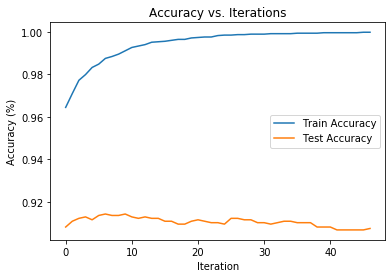

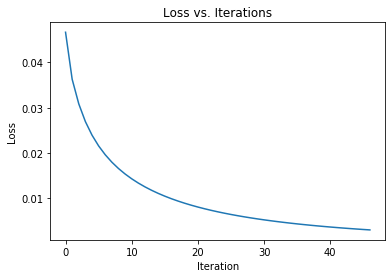

In [28]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.plot(losses)
plt.title('Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()